/var/folders/gy/z7x44kpn24d18spbg3w6_5fr0000gn/T/ipykernel_16947/3486993425.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(start="2023-01-01", end="2023-12-31 23:00", freq='H')  # Generate hourly timestamps for the entire year


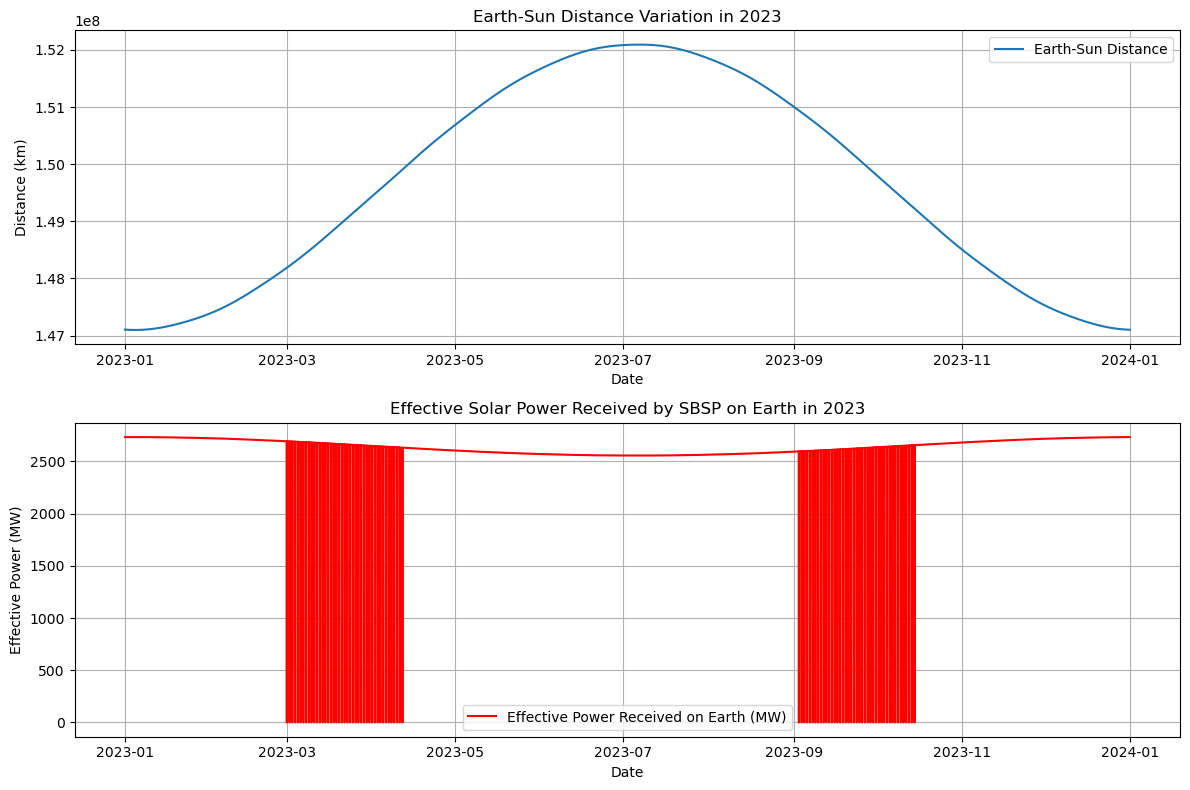

In [1]:
from skyfield.api import load  # Import Skyfield library to load astronomical data
import pandas as pd  
import matplotlib.pyplot as plt  
import numpy as np  
import xarray as xr  

# Load astronomical data
ts = load.timescale()  # Load time scale for astronomical calculations
eph = load('de421.bsp')  # Load DE421 ephemeris file containing positions of celestial bodies
earth = eph['earth']  # Define Earth object from the ephemeris
sun = eph['sun']  # Define Sun object from the ephemeris

# Create time series data for the year 2023
time = pd.date_range(start="2023-01-01", end="2023-12-31 23:00", freq='H')  # Generate hourly timestamps for the entire year

# Initialize list to store distances in km
distance_km = []

# Calculate the distance between Earth and Sun for each hour
for single_time in time:  # Loop through each hourly timestamp
    t = ts.utc(single_time.year, single_time.month, single_time.day, single_time.hour)  # Convert to Skyfield time object
    earth_at = earth.at(t)  # Get the position of Earth at time t
    distance_km.append(earth_at.observe(sun).distance().km)  # Calculate and store distance from Earth to Sun in km

# Create DataFrame to store the results
distance_data = pd.DataFrame({
    'Date': time,  # Add timestamp column
    'Distance (km)': distance_km  # Add distance column in km
})

# Calculate the solar power density received
solar_constant = 1367.5  # Solar constant in W/m² at 1 AU
power_density = [solar_constant * (1 / (distance / 1.496e8))**2 for distance in distance_km]  # Adjust solar constant for distance in km

# Define the area of the solar panels in square meters
solar_panel_area = 11.473 * 1e6  # Area in square meters (converted from square kilometers)
scaling_factor = 0.77

# Calculate the total power received by the solar panels in MW
received_power = [pd * solar_panel_area / scaling_factor/ 1e6 for pd in power_density]  # Calculate power in MW

# Define efficiency factors
solar_cell_efficiency = 0.35  # Efficiency of the solar cells
dc_to_dc_efficiency = 0.9  # DC-to-DC conversion efficiency
dc_to_rf_efficiency = 0.7  # DC-to-RF conversion efficiency
antenna_efficiency = 0.9  # Efficiency of the transmitting antenna
atmospheric_transmission_efficiency = 0.98  # Efficiency of atmospheric transmission
beam_collection_efficiency = 0.95  # Efficiency of beam collection
receiver_antenna_efficiency = 0.78  # Efficiency of the receiving antenna
ground_dc_to_dc_efficiency = 0.9  # DC-to-DC conversion efficiency on the ground


# Calculate the effective power received on Earth, considering efficiency factors
effective_power = [
    rp * solar_cell_efficiency * dc_to_dc_efficiency * dc_to_rf_efficiency * antenna_efficiency *
    atmospheric_transmission_efficiency * beam_collection_efficiency * receiver_antenna_efficiency *
    ground_dc_to_dc_efficiency for rp in received_power
]  # Calculate effective power in MW

# Add the effective power to the DataFrame
distance_data['Effective Power (MW)'] = effective_power            
# Define eclipse periods where power is set to 0
eclipse_periods = [
    ('2023-02-28', '2023-04-11'),  # Spring eclipse period
    ('2023-09-02', '2023-10-14')  # Autumn eclipse period
]

# Set power to 0 during eclipse periods
for start_date, end_date in eclipse_periods:  # Loop through each eclipse period
    eclipse_dates = pd.date_range(start=start_date, end=end_date, freq='D')  # Generate daily timestamps for each eclipse period
    for eclipse_day in eclipse_dates:  # Loop through each day in the eclipse period
        start_time = pd.Timestamp(eclipse_day) + pd.Timedelta(hours=18, minutes=0)  # Define start time of eclipse
        end_time = start_time + pd.Timedelta(minutes=70)  # Define end time of eclipse (70 minutes later)
        mask = (distance_data['Date'] >= start_time) & (distance_data['Date'] <= end_time)  # Create mask for eclipse period
        distance_data.loc[mask, 'Effective Power (MW)'] = 0  # Set effective power to 0 during eclipse

# Convert DataFrame to xarray Dataset
dataset = distance_data.set_index('Date').to_xarray()

# Save to NetCDF file
dataset.to_netcdf('sbsp_rd1_profile_2023.nc')

# Save to CSV file
distance_data.to_csv('sbsp_rd1_profile_2023.csv', index=False)

# Plot the Earth-Sun distance and the effective power received on Earth
plt.figure(figsize=(12, 8))

# Plot the Earth-Sun distance
plt.subplot(2, 1, 1)
plt.plot(distance_data['Date'], distance_data['Distance (km)'], label='Earth-Sun Distance')
plt.xlabel('Date')
plt.ylabel('Distance (km)')
plt.title('Earth-Sun Distance Variation in 2023')
plt.legend()
plt.grid(True)

# Plot the effective solar power received
plt.subplot(2, 1, 2)
plt.plot(distance_data['Date'], distance_data['Effective Power (MW)'], label='Effective Power Received on Earth (MW)', color='red')
plt.xlabel('Date')
plt.ylabel('Effective Power (MW)')
plt.title('Effective Solar Power Received by SBSP on Earth in 2023')
plt.legend()
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [2]:
import xarray as xr

dataset = xr.open_dataset('sbsp_rd1_profile_2023.nc')

print(dataset)

print(dataset.data_vars)

print(dataset['Effective Power (MW)'])

<xarray.Dataset> Size: 210kB
Dimensions:               (Date: 8760)
Coordinates:
  * Date                  (Date) datetime64[ns] 70kB 2023-01-01 ... 2023-12-3...
Data variables:
    Distance (km)         (Date) float64 70kB ...
    Effective Power (MW)  (Date) float64 70kB ...
Data variables:
    Distance (km)         (Date) float64 70kB ...
    Effective Power (MW)  (Date) float64 70kB ...
<xarray.DataArray 'Effective Power (MW)' (Date: 8760)> Size: 70kB
[8760 values with dtype=float64]
Coordinates:
  * Date     (Date) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
